In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
from scipy.integrate import solve_ivp 
from numpy.random import MT19937, RandomState, SeedSequence
from matplotlib import animation

In [5]:
class KuramotoHemisphere(): 
    '''
    The KuramotoHemisphere class implements the Kuramoto model on a hemispherical surface to simulate synchronized oscillations.

    Key components:

    Constructor parameters:
    epsilon: Coupling strength between oscillators
    eta: Non-linear coupling parameter
    sigma: Standard deviation of natural frequencies
    mean_omega: Mean natural frequency
    grad: Gradient parameter (default=0)

    Main methods:
    initialise(N, T, n_frames, seed): Sets up the simulation with N oscillators over time T with specified number of frames
    evolve(): Runs the time evolution using LSODA solver
    _rhs(): Hidden function. Defines the right-hand side of the differential equations
    _coupling(): Hidden function. Implements the coupling function between oscillators

    Lattice generation:
    Uses Fibonacci lattice to generate points on a hemisphere
    Employs Delaunay triangulation to determine nearest neighbors
    Points are distributed using golden angle spacing for uniform coverage

    Frequency distribution:
    Natural frequencies (omegas) are randomly generated
    Can be seeded for reproducibility
    Follows normal distribution with specified mean and standard deviation
    The model creates a network of coupled oscillators on a hemispherical surface, useful for studying synchronization phenomena in biological systems like cell division waves.
    '''
    
    def __init__(self, epsilon, eta, sigma, mean_omega, grad=0):
        # Initialises the class with the model parameters 
        self.epsilon = epsilon 
        self.eta = eta 
        self.sigma = sigma
        self.mean_omega = mean_omega 
        self.grad = grad  
        
    def initialise(self, N, T, n_frames, seed=None): 
        self.size = N
        self.T = T 
        self.n_frames = int(n_frames)
        self.initial_state = np.zeros((N))
        
        self._make_lattice()
        self._set_omegas(seed)
        
    def evolve(self): 
        
        t_eval = np.linspace(0, self.T-1, self.n_frames)
        coupling = np.empty(self.size)
        self.res = solve_ivp(self._rhs, [0, self.T], self.initial_state, method='LSODA', 
                          t_eval=t_eval, args=[coupling])
        
        
    def _rhs(self, t, theta, coupling): 
        
        for i in range(self.size): 
            nn = self.neighbours[self.locs[i]:self.locs[i+1]]
            d_thetas = theta[nn] - theta[i]
            coupling[i] = np.sum(self._coupling(d_thetas))
        rhs = self.epsilon*coupling + self.omegas
        
        return rhs
    
    def _coupling(self, d_theta): 
        return np.sin(d_theta) + self.eta*(1-np.cos(d_theta))
        
    def _make_lattice(self): 
        self.x, self.y, self.z = self._fibo_hemisphere() 
        self.tri = Delaunay(np.stack([self.x, self.y]).T)
        self.locs, self.neighbours = self.tri.vertex_neighbor_vertices
        self.boundary = [self.z == 0]
        
    def _fibo_hemisphere(self):
        ga = (3 - np.sqrt(5)) * np.pi # golden angle                                                                                                                        
        theta = ga * np.arange(self.size)                                                
        z = np.linspace(0, 1-1/self.size, self.size)
                                                       
        radius = np.sqrt(1 - z * z)                                          
        y = radius * np.sin(theta)
        x = radius * np.cos(theta)
        return x, y, z
        
    def _set_omegas(self, seed): 
        if seed is None:
            self.omegas = self.sigma*np.random.normal(size=(self.size)) + self.mean_omega
        else: 
            rs = RandomState(MT19937(SeedSequence(seed)))
            self.omegas = self.sigma*rs.normal(size=(self.size)) + self.mean_omega 

In [54]:
def find_division_timings(thetas, T): 
    """
    Calculates the division timing for each oscillator in the Kuramoto model simulation.
    
    Parameters:
    -----------
    thetas : ndarray
        2D array of phase angles (thetas) for N oscillators over time, 
        with shape (N, n_frames)
    
    Returns:
    --------
    division_time : ndarray
        1D array of normalized division times for each oscillator, 
        shifted so the earliest division starts at t=0
        
    Notes:
    ------
    - Division is considered to occur when theta < π/12
    - For each oscillator, takes the last occurrence of division
    - Times are normalized by n_frames/T
    """
    N = thetas.shape[0] 
    n_frames = thetas.shape[1]
    indices = np.argwhere(thetas < np.pi/12)
    division_time = np.array([indices[indices[:, 0] == i][-1, 1] for i in range(N)])/(n_frames/T)
    division_time -= min(division_time)
    return division_time


def find_std_all_rounds(thetas, T, mean_omega, num_periods=8):
    """
    Calculates the standard deviation of division times for each round of oscillations. 
    
    Parameters:
    -----------
    thetas : ndarray
        2D array of phase angles for N oscillators over time, shape (N, n_frames)
    T : float
        Total simulation time
    mean_omega : float
        Mean natural frequency of the oscillators
    num_periods : int
        Number of oscillation periods to analyze (default value is 8)
        
    Returns:
    --------
    stds : ndarray
        Array of standard deviations for each division round
        
    Notes:
    ------
    - Identifies division events when theta < π/60
    - Groups division times into rounds based on proximity to expected period times
    - Calculates standard deviation for each round to measure synchronization
    """ 
    n_frames = thetas.shape[1]
    division_times = np.argwhere(thetas < np.pi/30)/(n_frames/T)
    period = 2*np.pi/mean_omega*0.99
    expected_time = period*np.arange(num_periods)
    time_difference = np.abs(division_times[:, 1, np.newaxis] - expected_time[np.newaxis, :])
    round_number = np.argmin(time_difference, axis=-1)
    stds =  np.array([np.std(division_times[round_number == n, 1]) for n in range(num_periods)])
    return stds 


def plot_division_times(Ts, model, epsilon, sigma, show=False):
    '''
    Plots the division times for each oscillator in the Kuramoto model simulation.
    '''
    fig, axes = plt.subplots(2, 5, figsize=(20, 6))

    for (i, division_time) in enumerate(Ts):

        indices = np.unravel_index(i, (2, 5))
        axes[indices].tricontourf(model.x, model.y, division_time, cmap='viridis')
        axes[indices].scatter(model.x, model.y, color='k',  s = model.z*10, marker='o', edgecolors='k')
        axes[indices].axis('off')
        fig.colorbar(axes[indices].collections[0], ax=axes[indices])

    plt.savefig("Sims/plots/epsilon={:.2}_sigma={:.2}.png".format(epsilon, sigma), bbox_inches='tight', dpi=400)
    if show: 
        plt.show()
    plt.close() 

In [4]:
# Set up model parameters 
epsilon = 0.25
eta = 0 # asymmetry parameter
mean_omega = 2*np.pi/(28.3) # mean natural frequency
sigma =  mean_omega*0.25 # disorder
g = 0

# Set up simulation parameters 
N = 64
T = 210
n_frames = T*10

n_samples = 10 
seeds = [None]*n_samples 



# Initialise the model and run the simulation
epsilons = np.linspace(0, 0.2, 21) 
sigmas = mean_omega*np.linspace(0, 0.5, 21)
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

for epsilon in epsilons: 
    for sigma in sigmas: 
        for seed in seeds:
            filename = 'Sims/epsilon_{:.2}_sigma_{:.2}_seed_{}_theta.npy'.format(epsilon, sigma, seed)
            model = KuramotoHemisphere(epsilon, eta, sigma, 0)
            model.initialise(N, T, n_frames, seed=seed) 
            model.omegas += mean_omega/(1-model.z/np.max(model.z)*0.019)
            model.evolve() 
            np.save(filename, model.res.y % (2*np.pi))

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
Python runtime state: initialized
    return self.fun_single(t, y)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
                      ^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py", line 593, in fun
    return fun(t, x, *args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_63064/1985603557.py", line 62, in _rhs
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 2313, in sum
    retur

: 

In [99]:
# Define the parameters needed to load the data 
mean_omega = 2*np.pi/(28.3) # mean natural frequency
N = 64
T = 210
n_frames = T*10
eta = 0 
epsilons = np.linspace(0, 0.2, 21) 
sigmas = mean_omega*np.linspace(0, 0.5, 21)
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 


Ts = [] 
stds = [] 
for epsilon in epsilons: 
    for sigma in sigmas:
        for seed in seeds:
            filename = 'Sims/epsilon_{:.2}_sigma_{:.2}_seed_{}_theta.npy'.format(epsilon, sigma, seed)
            thetas = np.load(filename) 
            division_time = find_division_timings(thetas, T)
            Ts.append(division_time) 
            stds.append(find_std_all_rounds(thetas, T, mean_omega, num_periods=8))

Ts = np.array(Ts).reshape((len(epsilons), len(sigmas), len(seeds), N))
std_last = np.std(Ts, axis=-1) 

stds = np.array(stds).reshape((len(epsilons), len(sigmas), len(seeds), 8))

In [104]:
m_std_last = np.mean(std_last, axis=-1)
m_stds = np.mean(stds, axis=2)

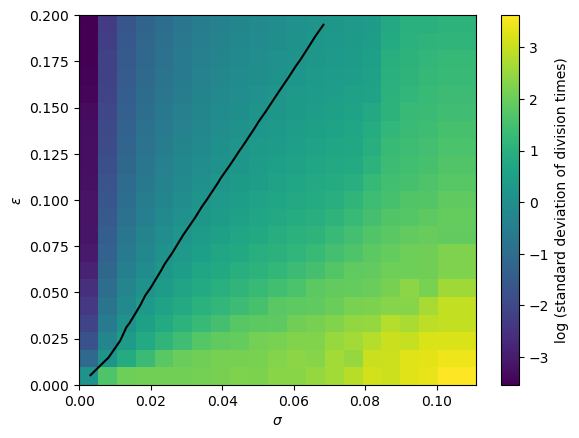

In [101]:
plt.imshow(np.log(m_std_last), extent=[sigmas[0], sigmas[-1], epsilons[0], epsilons[-1]], origin='lower', aspect='auto')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\epsilon$')
cbar = plt.colorbar()
cbar.set_label('log (standard deviation of division times)')
cs = plt.contour(np.log(m_std_last), levels=[np.log(1.22)], colors='black', extent=[sigmas[0], sigmas[-1], epsilons[0], epsilons[-1]], origin='lower')
plt.show()

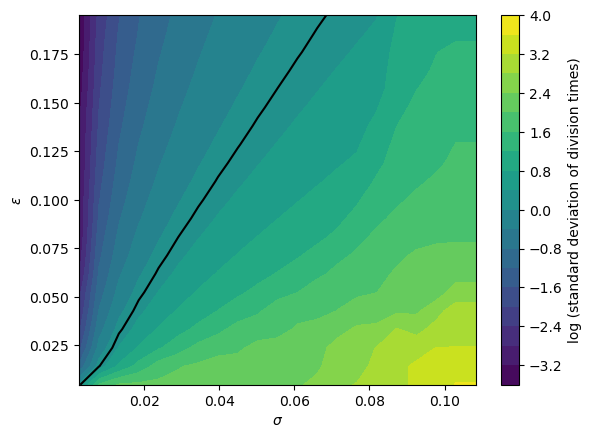

In [102]:
plt.contourf(np.log(m_std_last), extent=[sigmas[0], sigmas[-1], epsilons[0], epsilons[-1]], levels=20, origin='lower')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\epsilon$')
cbar = plt.colorbar()
cbar.set_label('log (standard deviation of division times)')
cs = plt.contour(np.log(m_std_last), levels=[np.log(1.22)], colors='black', extent=[sigmas[0], sigmas[-1], epsilons[0], epsilons[-1]], origin='lower')
plt.show()

In [103]:
epsilon_indices, sigma_indices = np.nonzero(np.abs(m_std_last- 1.22)< 0.05)
sigma_indices = np.insert(sigma_indices, 0, 0)
epsilon_indices = np.insert(epsilon_indices, 0, 0)

In [73]:
for (i, j) in zip(epsilon_indices, sigma_indices):
    sigma = sigmas[j] 
    epsilon = epsilons[i]
    division_times = Ts[i, j].reshape((10, N))

    model = KuramotoHemisphere(epsilon, eta, sigma, 0)
    model.initialise(N, T, n_frames, seed=seed) 
    model.omegas += mean_omega/(1-model.z/np.max(model.z)*0.019)
    plot_division_times(division_times, model, epsilon, sigma, show=False)

1.1152167933158772
[1.11857874 1.11857874 1.11857874 1.11857874 1.11857874 1.11857874
 1.11857874 1.11857874 1.11857874 1.11857874]
1.174206586763352
[0.87357498 0.88808434 1.04835996 0.91076866 0.98767398 1.17874215
 0.74541708 1.56910737 0.6646881  0.80574561]
1.1931700161754002
[0.86951373 0.90914354 1.05709322 0.91790391 1.00013902 1.19773592
 0.76026304 1.6268784  0.65291071 0.81952599]
1.1888988368805562
[0.87943942 0.92342149 1.08502703 0.9334214  1.00840666 1.20191363
 0.75801763 1.60710094 0.64941188 0.81918576]
1.1947623223201909
[0.86963049 0.91696379 1.07322007 0.92010611 0.99003169 1.21345185
 0.77254373 1.61325011 0.64904626 0.82672329]
1.2050724498448229
[0.85445863 0.91504709 1.06940377 0.92245021 1.00590056 1.22347321
 0.77802117 1.61280143 0.64924598 0.8264929 ]
1.1961028739038027
[0.86922156 0.91510421 1.07165328 0.91783745 1.01073549 1.21543852
 0.77095556 1.62383703 0.64790526 0.82272395]
1.1998485825693797
[0.88136233 0.9269729  1.0711904  0.91292515 1.01666264 1.

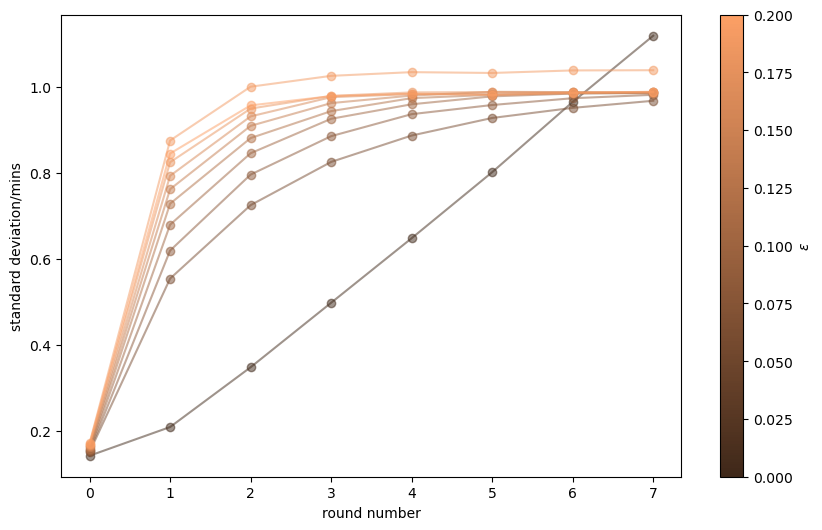

In [ ]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create custom colormap using only a portion of viridis
base_cmap = plt.cm.copper
subset_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    'custom', 
    base_cmap(np.linspace(0.2, 0.8, 256))  # Use 20% to 80% of the colormap
)

# Create a colormap based on epsilon values
norm = plt.Normalize(min(epsilons[epsilon_indices]), max(epsilons[epsilon_indices]))
cmap = subset_cmap

for (i, j) in zip(epsilon_indices, sigma_indices):
    epsilon = epsilons[i]
    single_std = m_stds[i, j]
    ax.plot(single_std, 'o-', alpha=0.5, color=cmap(norm(epsilon)))
    print(std_last[i, j])
    print(stds[i, j, :, -1])

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax, label='$\epsilon$')
plt.xlabel('round number')
plt.ylabel('standard deviation/mins')
plt.show()



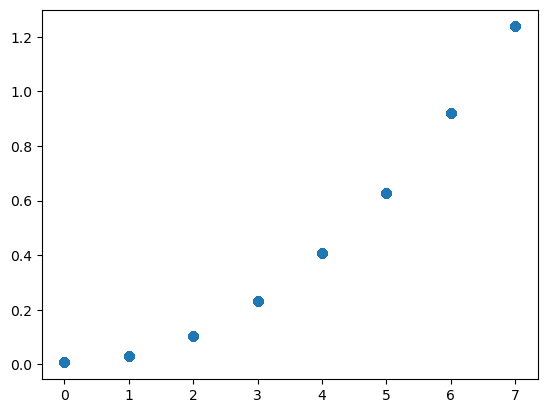

In [11]:
epsilon = 0.
sigma = 0. 

filename = 'Sims/epsilon_{:.2}_sigma_{:.2}_seed_{}_theta.npy'.format(epsilon, sigma, seed)
thetas = np.load(filename)

division_times = np.argwhere(thetas < np.pi/60)/(n_frames/T)
num_periods = 8 
period = 2*np.pi/mean_omega 
expected_time = period*np.arange(num_periods)
time_difference = np.abs(division_times[:, 1, np.newaxis] - expected_time[np.newaxis, :])
round_number = np.argmin(time_difference, axis=-1)
stds =  np.array([np.std(division_times[round_number == n, 1]) for n in round_number])

plt.plot(round_number, stds**2, 'o')
plt.show() 

In [160]:
# Reshape the result into 2D shape 
N = 100 # number of frames to use in making the movie 

phase_evolution = model.res.y[:, ::int(n_frames/N)].T % (2*np.pi)
print(phase_evolution.shape)

# Set up figure plotting 
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

vmin = 0
vmax = 2*np.pi

p1 = ax.scatter(model.x, model.y, c=phase_evolution[0], vmin=vmin, vmax=vmax, cmap='twilight')
fig.colorbar(p1, ax=ax, shrink=0.8)
ax.axis('off')
panels = [p1]

def animate(i): 

    panels[0].set_array(phase_evolution[i])
    return panels

ani = animation.FuncAnimation(fig, animate, interval=50, blit=True,
                                repeat_delay=1000, frames=N)
plt.close() 

(100, 200)


In [206]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=2000)

ani.save('sim.mp4', writer=writer, dpi=200)